In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
import pandas as pd
import os
import tempfile

In [3]:
# Constants 
SKETCHY_DATABASE_PATH = "~/sketchy-database/"

**Issues:**
1. stats.csv "Category" contains names with spaces, however database directory names don't contain space but underscore.
2. testset.txt image extension is JPEG, whereas the database uses PNG

## Data preparation
### Train test split

In [27]:
class SketchyDatabase(object):
    
    DefaultSketchAugmentation = 5
    SketchAugmentations = ["tx_000000000000", "tx_000000000010", "tx_000000000110", 
                       "tx_000000001010",  "tx_000000001110",  "tx_000100000000"]

    def __init__(self, database_root, augmentation=None):
        
        self.database_root = os.path.expanduser(database_root)
        
        if not augmentation:
            augmentation = SketchyDatabase.SketchAugmentations[SketchyDatabase.DefaultSketchAugmentation]
            
        self.augmentation = augmentation
        self.sketch_img_path = os.path.join(self.database_root, "rendered_256x256/256x256/sketch", self.augmentation)
        self.__read_data()
    
    def __read_data(self):
        
        # read sketch data
        self.sketch_stats_df = pd.read_csv(os.path.join(self.database_root, "info/stats.csv"))
        
        # Fix "Category" name (See above: issue no. 1)
        self.sketch_stats_df["Category"] = self.sketch_stats_df["Category"].apply(lambda x: x.replace(" ", "_"))
        
        self.sketch_invalid_ambiguous_df = pd.read_csv(
                                os.path.join(self.database_root, "info/invalid-ambiguous.txt"), header=None)
        self.sketch_invalid_context_df = pd.read_csv(
                                os.path.join(self.database_root, "info/invalid-context.txt"), header=None)
        self.sketch_invalid_error_df = pd.read_csv(
                                os.path.join(self.database_root, "info/invalid-error.txt"), header=None)
        self.sketch_invalid_pose_df = pd.read_csv(
                                os.path.join(self.database_root, "info/invalid-pose.txt"), header=None)
        self.sketch_testset_df = pd.read_csv(
                                os.path.join(self.database_root, "info/testset.txt"), header=None)
        
        # Add new column for convenience
        # Sketch image file name = <ImageNetID>-<SketchID>."png"
        self.sketch_stats_df["_img_file_name"] = self.sketch_stats_df["ImageNetID"] \
                                                    + "-" + self.sketch_stats_df["SketchID"].map(str)
            
        self.sketch_stats_df["_img_file_path"] = self.sketch_stats_df.apply(
                        lambda row: os.path.expanduser(
                                        os.path.join(os.path.join(self.sketch_img_path, row["Category"]),
                                                    row["_img_file_name"] + ".png")
                                    )
                    , axis=1)
        
        # read image data
        # ... TODO
        
    def generate_train_test_split(self, with_ambiguous=False, with_context=False, 
                                                  with_error=False, with_pose=False):
  
        sketch_df = self.sketch_stats_df #.copy(deep=True) # don't modify destructively

        if not with_ambiguous:
            sketch_df = sketch_df.loc[~self.sketch_stats_df["_img_file_name"].isin(self.sketch_invalid_ambiguous_df[0])]
        if not with_context:
            sketch_df = sketch_df.loc[~self.sketch_stats_df["_img_file_name"].isin(self.sketch_invalid_context_df[0])]
        if not with_error:
            sketch_df = sketch_df.loc[~self.sketch_stats_df["_img_file_name"].isin(self.sketch_invalid_error_df[0])]
        if not with_pose:
            sketch_df = sketch_df.loc[~self.sketch_stats_df["_img_file_name"].isin(self.sketch_invalid_pose_df[0])]

        # Databse images are in png format, but testset lists them as jpg, 
        # just blending in with the inconsistency for now (See above: issue no. 2)
        is_test_sample = sketch_df["ImageNetID"].isin(self.sketch_testset_df[0].apply(
                                            lambda x: x.split("/")[1].split('.jpg')[0]))
        sketch_df["_split"] = "train"
        sketch_df["_split"].loc[is_test_sample] = "test"
        self.sketch_stats_df = sketch_df
        
    def get_caffeinated_dataset(self, split="train"):
        
        assert(split=="train" or split=="test")
        
        sketch_stats_filtered_df = self.sketch_stats_df[self.sketch_stats_df["_split"]==split]
        with tempfile.NamedTemporaryFile(delete=False) as f:
            for _,row in sketch_stats_filtered_df.iterrows():
                f.write(row["_img_file_path"] + " " + str(row["CategoryID"]) + "\n")
        return f.name

In [28]:
sketchy_database = SketchyDatabase(SKETCHY_DATABASE_PATH)
sketchy_database.generate_train_test_split(with_ambiguous=False, with_context=False, with_error=False, with_pose=False)

## Data Exploration

In [29]:
import matplotlib.gridspec as gridspec

def vis_samples(sketch_df, sketch_img_path, grid_size=(None, None), max_tiles=100):
    
    sketch_df = sketch_df[:max_tiles].copy()
    n_imgs = len(sketch_df)
    n_rows, n_cols = grid_size
    
    if n_rows == None or n_cols == None: 
        n_cols = int(np.ceil(np.sqrt(n_imgs)))
        n_rows = int(np.ceil(1.*n_imgs/n_cols))
    
    gs = gridspec.GridSpec(n_rows, n_cols)    
    for idx, (category, img_file_path) in enumerate(sketch_df[["Category", "_img_file_path"]].values):
        plt.subplot(gs[idx]), plt.axis("off")
        img = plt.imread(img_file_path)
        plt.imshow(img)
        plt.title(category)

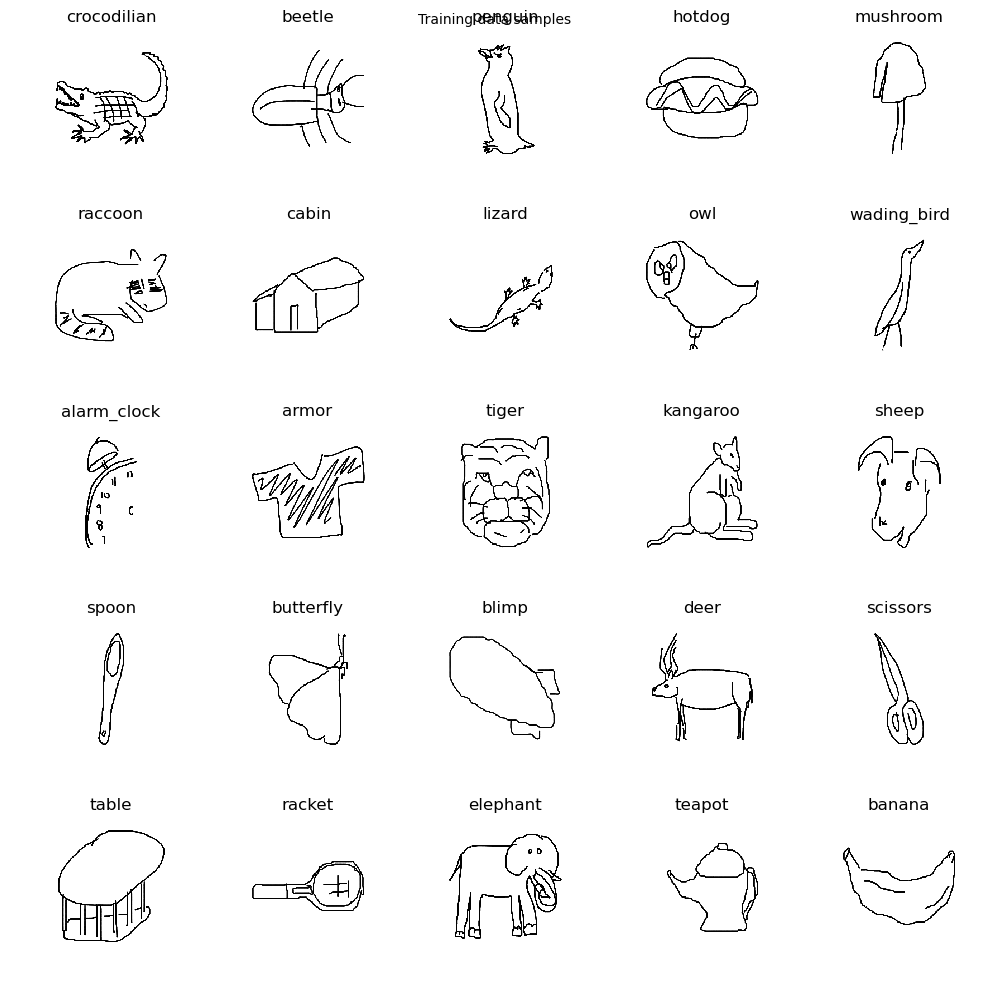

In [30]:
np.random.seed(0)
disp_samples = 25
train_df = sketchy_database.sketch_stats_df[sketchy_database.sketch_stats_df["_split"] == "train"]

rand_locations = np.random.choice(train_df.index, disp_samples, replace=False)
vis_samples(train_df.loc[rand_locations], sketchy_database.sketch_img_path)
plt.suptitle("Training data samples")
plt.tight_layout()

In [31]:
train_img_list_file = sketchy_database.get_caffeinated_dataset()
test_img_list_file = sketchy_database.get_caffeinated_dataset(split="test")

## Fine-tuning a Pretrained Network for Sketch Recognition

Adapted from: https://github.com/BVLC/caffe/blob/master/examples/02-fine-tuning.ipynb 


In [9]:
caffe_root = os.path.expanduser('~/caffe')  # this file should be run from {caffe_root}/examples (otherwise change this line)

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

# caffe.set_device(0)
# caffe.set_mode_gpu()
caffe.set_mode_cpu()

# Helper function for deprocessing preprocessed images, e.g., for display.
def deprocess_net_image(image):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

In [10]:
os.chdir(caffe_root)  # run scripts from caffe root
!data/ilsvrc12/get_ilsvrc_aux.sh
!scripts/download_model_binary.py models/bvlc_reference_caffenet

ImageNet example aux files already exist.
Model already exists.


In [11]:
weights = os.path.join(caffe_root, 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')
assert os.path.exists(weights)

In [12]:
weights

'/root/caffe/models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

In [13]:
# Load ImageNet labels to imagenet_labels
imagenet_label_file = os.path.join(caffe_root, 'data/ilsvrc12/synset_words.txt')
imagenet_labels = list(np.loadtxt(imagenet_label_file, str, delimiter='\t'))
assert len(imagenet_labels) == 1000
print 'Loaded ImageNet labels:\n', '\n'.join(imagenet_labels[:10] + ['...'])



Loaded ImageNet labels:
n01440764 tench, Tinca tinca
n01443537 goldfish, Carassius auratus
n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
n01491361 tiger shark, Galeocerdo cuvieri
n01494475 hammerhead, hammerhead shark
n01496331 electric ray, crampfish, numbfish, torpedo
n01498041 stingray
n01514668 cock
n01514859 hen
n01518878 ostrich, Struthio camelus
...


In [14]:
sketchy_sketch_labels = sketchy_database.sketch_stats_df["Category"].unique()
assert len(sketchy_sketch_labels) == 125
print 'Loaded Sketchy sketch labels:\n', ', '.join(sketchy_sketch_labels)
NUM_SKETCHY_SKETCH_LABELS = len(sketchy_sketch_labels)

Loaded Sketchy sketch labels:
airplane, alarm_clock, ant, ape, apple, armor, axe, banana, bat, bear, bee, beetle, bell, bench, bicycle, blimp, bread, butterfly, cabin, camel, candle, cannon, car_(sedan), castle, cat, chair, chicken, church, couch, cow, crab, crocodilian, cup, deer, dog, dolphin, door, duck, elephant, eyeglasses, fan, fish, flower, frog, geyser, giraffe, guitar, hamburger, hammer, harp, hat, hedgehog, helicopter, hermit_crab, horse, hot-air_balloon, hotdog, hourglass, jack-o-lantern, jellyfish, kangaroo, knife, lion, lizard, lobster, motorcycle, mouse, mushroom, owl, parrot, pear, penguin, piano, pickup_truck, pig, pineapple, pistol, pizza, pretzel, rabbit, raccoon, racket, ray, rhinoceros, rifle, rocket, sailboat, saw, saxophone, scissors, scorpion, sea_turtle, seagull, seal, shark, sheep, shoe, skyscraper, snail, snake, songbird, spider, spoon, squirrel, starfish, strawberry, swan, sword, table, tank, teapot, teddy_bear, tiger, tree, trumpet, turtle, umbrella, violin,

In [15]:
from caffe import layers as L
from caffe import params as P

weight_param = dict(lr_mult=1, decay_mult=1)
bias_param   = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

frozen_param = [dict(lr_mult=0)] * 2

def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='gaussian', std=0.01),
              bias_filler=dict(type='constant', value=0.1)):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='gaussian', std=0.005),
            bias_filler=dict(type='constant', value=0.1)):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def caffenet(data, label=None, train=True, num_classes=1000,
             classifier_name='fc8', learn_all=False):
    """Returns a NetSpec specifying CaffeNet, following the original proto text
       specification (./models/bvlc_reference_caffenet/train_val.prototxt)."""
    n = caffe.NetSpec()
    n.data = data
    param = learned_param if learn_all else frozen_param
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4, param=param)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2, param=param)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1, param=param)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2, param=param)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2, param=param)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096, param=param)
    if train:
        n.drop6 = fc7input = L.Dropout(n.relu6, in_place=True)
    else:
        fc7input = n.relu6
    n.fc7, n.relu7 = fc_relu(fc7input, 4096, param=param)
    if train:
        n.drop7 = fc8input = L.Dropout(n.relu7, in_place=True)
    else:
        fc8input = n.relu7
    # always learn fc8 (param=learned_param)
    fc8 = L.InnerProduct(fc8input, num_output=num_classes, param=learned_param)
    # give fc8 the name specified by argument `classifier_name`
    n.__setattr__(classifier_name, fc8)
    if not train:
        n.probs = L.Softmax(fc8)
#     print label.to_proto()
    if label is not None:
        n.label = label
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)
    # write the net to a temporary file and return its filename
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(n.to_proto()))
        return f.name

In [16]:
dummy_data = L.DummyData(shape=dict(dim=[1, 3, 227, 227]))
imagenet_net_filename = caffenet(data=dummy_data, train=False)
imagenet_net = caffe.Net(imagenet_net_filename, weights, caffe.TEST)

In [17]:
img = plt.imread(train_df[:1]["_img_file_path"].values[0])

In [19]:
train_df["_img_file_path"].values

array([ '/root/sketchy-database/rendered_256x256/256x256/sketch/tx_000100000000/airplane/n02691156_11257-3.png',
       '/root/sketchy-database/rendered_256x256/256x256/sketch/tx_000100000000/airplane/n02691156_11257-5.png',
       '/root/sketchy-database/rendered_256x256/256x256/sketch/tx_000100000000/airplane/n02691156_11257-6.png',
       ...,
       '/root/sketchy-database/rendered_256x256/256x256/sketch/tx_000100000000/zebra/n02391049_9421-9.png',
       '/root/sketchy-database/rendered_256x256/256x256/sketch/tx_000100000000/zebra/n02391049_9421-10.png',
       '/root/sketchy-database/rendered_256x256/256x256/sketch/tx_000100000000/zebra/n02391049_9421-11.png'], dtype=object)

In [ ]:
/root/sketchy-database/rendered_256x256/256x256/sketch/tx_000100000000n02691156_10391-1.png

In [32]:
train_img_list_file

'/tmp/tmp1HFmUF'

In [33]:
def sketch_net(train=True, learn_all=False, subset=None):
    if subset is None:
        subset = 'train' if train else 'test'
    source = train_img_list_file if train else test_img_list_file
    # set mirror images = False
    transform_param = dict(mirror=False, crop_size=227,
        mean_file=os.path.join(caffe_root,'data/ilsvrc12/imagenet_mean.binaryproto'))
    
    #TODO: Note that future Caffe releases will only support transform_param messages for transformation fields!
    sketch_data, sketch_label = L.ImageData(
        transform_param=transform_param, source=source,
        batch_size=50, new_height=256, new_width=256, ntop=2)
    return caffenet(data=sketch_data, label=sketch_label, train=train,
                    num_classes=NUM_SKETCHY_SKETCH_LABELS,
                    classifier_name='fc8_sketchy_sketch',
                    learn_all=learn_all)

In [40]:
untrained_sketch_net = caffe.Net(sketch_net(train=False, subset='train'),
                                weights, caffe.TEST)
untrained_sketch_net.forward()
sketch_data_batch = untrained_sketch_net.blobs['data'].data.copy()
sketch_label_batch = np.array(untrained_sketch_net.blobs['label'].data, dtype=np.int32)

In [38]:
style_data_batch.shape

(50, 3, 227, 227)

In [45]:
def disp_preds(net, image, labels, k=5, name='ImageNet'):
    input_blob = net.blobs['data']
    net.blobs['data'].data[0, ...] = image
    probs = net.forward(start='conv1')['probs'][0]
    top_k = (-probs).argsort()[:k]
    print 'top %d predicted %s labels =' % (k, name)
    print '\n'.join('\t(%d) cat=%d %5.2f%% %s' % (i+1, p, 100*probs[p], labels[p])
                    for i, p in enumerate(top_k))

def disp_imagenet_preds(net, image, top_k):
    disp_preds(net, image, imagenet_labels, k=top_k, name='ImageNet')

def disp_style_preds(net, image, top_k):
    disp_preds(net, image, sketchy_sketch_labels, k=top_k, name='style')

actual label = airplane


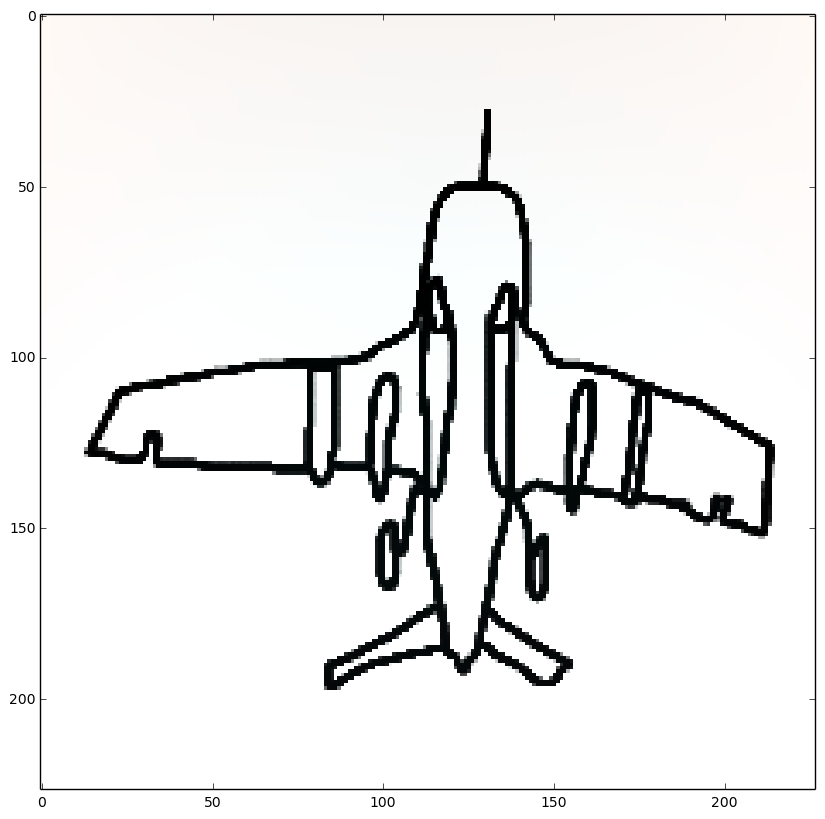

In [41]:
batch_index = 8
image = sketch_data_batch[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', sketchy_sketch_labels[sketch_label_batch[batch_index]]

In [48]:
disp_imagenet_preds(imagenet_net, image, 5)

top 5 predicted ImageNet labels =
	(1) cat=456 28.01% n02879718 bow
	(2) cat=830 27.06% n04336792 stretcher
	(3) cat=600 14.28% n03532672 hook, claw
	(4) cat=512  8.63% n03109150 corkscrew, bottle screw
	(5) cat=919  3.45% n06794110 street sign


In [47]:
disp_style_preds(untrained_sketch_net, image, 5)

top 5 predicted style labels =
	(1) cat=0  0.80% airplane
	(2) cat=90  0.80% scorpion
	(3) cat=89  0.80% scissors
	(4) cat=88  0.80% saxophone
	(5) cat=87  0.80% saw


In [49]:
diff = untrained_sketch_net.blobs['fc7'].data[0] - imagenet_net.blobs['fc7'].data[0]
error = (diff ** 2).sum()
assert error < 1e-8

In [50]:
del untrained_sketch_net